# 02 - Evaluate ResNet34 Model

This notebook loads the fine-tuned ResNet34 model and evaluates it on the test dataset.

In [1]:
# Imports
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Define test transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dir = '../data/test'
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
class_names = test_dataset.classes

In [3]:
# Load fine-tuned ResNet34
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load('../models/resnet34_best_model.pth', map_location=device))
model = model.to(device)
model.eval()

C:\Users\uriam\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\uriam\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Run inference
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [5]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.56      0.46      0.50       958
     disgust       0.29      0.73      0.42       111
        fear       0.47      0.34      0.39      1024
       happy       0.82      0.81      0.82      1774
     neutral       0.55      0.64      0.59      1233
         sad       0.51      0.40      0.45      1247
    surprise       0.59      0.85      0.70       831

    accuracy                           0.60      7178
   macro avg       0.54      0.60      0.55      7178
weighted avg       0.60      0.60      0.59      7178



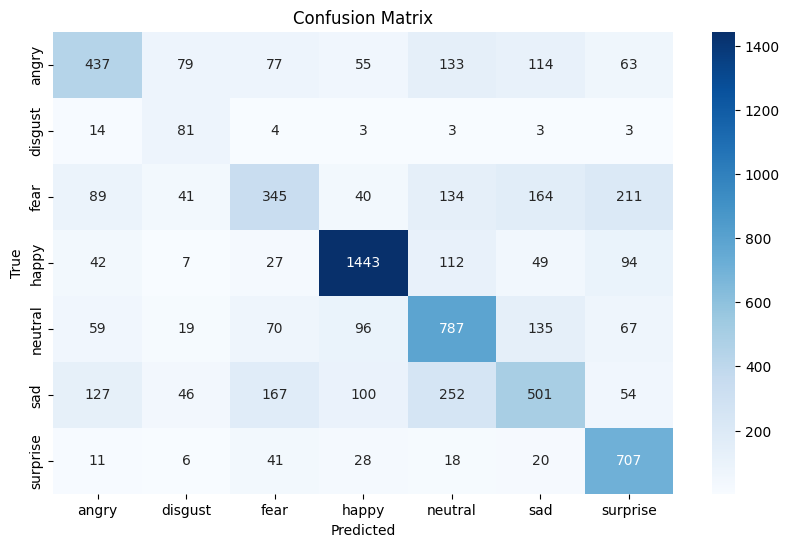

In [6]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()